In [72]:
import pandas as pd
from datetime import datetime
from geopy.distance import great_circle
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import ipywidgets as widgets
from IPython.display import display
import datetime as dt

In [2]:
# Define the path to your CSV file
file_path = 'matam_data/AFAD_1900_today_31461754_4_9.csv'

# Load the data
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())


                  Date  Longitude  Latitude  Depth Type  Magnitude Location  \
0  29/04/1903 16:07:56      42.65     39.15   33.0   MS        5.0        -   
1  30/04/1903 04:12:56      42.65     39.15   10.0   MS        4.6        -   
2  03/05/1903 01:56:56      41.50     38.70   10.0   MS        4.9        -   
3  21/05/1903 20:56:56      42.50     39.00   10.0   MS        4.2        -   
4  26/05/1903 08:05:56      29.00     40.65   10.0   MS        5.9        -   

   EventID               TimeName               TypeName  \
0     7821  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
1     7822  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
2     7823      Ayhan ve Diğ.1981      Ayhan ve Diğ.1981   
3     7824  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
4     7825  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   

           MagnitudeName  
0  Ambraseys-Finkel 1987  
1  Ambraseys-Finkel 1987  
2      Ayhan ve Diğ.1981  
3  Ambraseys-Finkel 1987  
4  Ambraseys-Finkel 1987  


In [79]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')

def filter_earthquakes(center, radius, time_interval):
    """
    Filters the earthquake incidents based on the center coordinate, radius, and time interval.

    Parameters:
    center (tuple): A tuple containing the latitude and longitude of the center point (latitude, longitude).
    radius (float): The radius in kilometers.
    time_interval (tuple): A tuple containing the start and end dates in 'YYYY-MM-DD' format (start_date, end_date).

    Returns:
    pd.DataFrame: A dataframe containing the filtered earthquake incidents.
    """
    # Unpack the time interval
    start_date, end_date = time_interval
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter data based on the time interval
    time_filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Function to calculate distance
    def calculate_distance(row):
        return great_circle(center, (row['Latitude'], row['Longitude'])).km

    # Calculate distances
    # time_filtered_data['Distance'] = time_filtered_data.apply(calculate_distance, axis=1)
    # time_filtered_data['Distance'] = time_filtered_data.apply(lambda row: calculate_distance(row), axis=1)
    time_filtered_data['Distance'] = time_filtered_data.apply(lambda row: pd.Series(calculate_distance(row)), axis=1)



    # Filter based on radius
    radius_filtered_data = time_filtered_data[time_filtered_data['Distance'] <= radius]

    return radius_filtered_data

In [20]:
# Example usage
center_coordinate = (37.288, 37.043)  # Latitude, Longitude
radius_in_km = 100.0
time_interval = ('2023-02-04', '2023-02-08') # year-month-day

filtered_earthquakes = filter_earthquakes(center_coordinate, radius_in_km, time_interval)
print(filtered_earthquakes.head())

                     Date  Longitude  Latitude  Depth Type  Magnitude  \
14924 2023-02-06 04:28:16     36.920    37.304   6.20   MW        6.6   
14925 2023-02-06 05:17:40     36.701    37.096   6.38   MW        4.9   
14926 2023-02-06 04:26:49     36.992    37.235   6.98   ML        5.6   
14928 2023-02-06 04:36:28     36.639    37.128  11.19   ML        5.7   
14929 2023-02-06 05:34:16     37.286    37.551  10.50   MW        4.6   

                       Location  EventID TimeName TypeName MagnitudeName  \
14924       Nurdağı (Gaziantep)   543431     AFAD     AFAD          AFAD   
14925      İslahiye (Gaziantep)   543435     AFAD     AFAD          AFAD   
14926       Nurdağı (Gaziantep)   543429     AFAD     AFAD          AFAD   
14928     Hasanbeyli (Osmaniye)   543430     AFAD     AFAD          AFAD   
14929  Pazarcık (Kahramanmaraş)   543440     AFAD     AFAD          AFAD   

        Distance  
14924  11.024765  
14925  37.061244  
14926   7.423086  
14928  39.957844  
14929  36

/var/folders/sc/txcp_vws5hsbztxf_d9wby9w0000gn/T/ipykernel_64187/791687869.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_data['Distance'] = time_filtered_data.apply(calculate_distance, axis=1)


In [94]:
def plot_earthquake_heatmap(center, radius, time_interval, time_increment):
    """
    Plots a heatmap of earthquake magnitudes within specified time increments.

    Parameters:
    center (tuple): A tuple containing the latitude and longitude of the center point (latitude, longitude).
    radius (float): The radius in kilometers.
    time_interval (tuple): A tuple containing the start and end dates in 'YYYY-MM-DD' format (start_date, end_date).
    time_increment (str): A string representing the time increment, e.g., '7D' for 7 days, '1M' for 1 month.
    """
    # Filter earthquakes based on the center, radius, and time interval
    earthquakes = filter_earthquakes(center, radius, time_interval)

    # Define the bins for magnitudes
    magnitude_bins = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]
    magnitude_labels = ['3-3.5', '3.5-4', '4-4.5', '4.5-5', '5-5.5', '5.5-6', '6-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-9']
    
    # Initialize a dictionary to store histogram data
    time_slots = []
    histogram_data = {label: [] for label in magnitude_labels}
    
    # Calculate the time increments
    start_date, end_date = time_interval
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    current_date = start_date

    while current_date < end_date:
        if 'D' in time_increment:
            next_date = current_date + pd.Timedelta(time_increment)
        elif 'M' in time_increment:
            next_date = current_date + pd.DateOffset(months=int(time_increment[:-1]))
        else:
            raise ValueError("Unsupported time increment format. Use 'D' for days or 'M' for months.")

        if next_date > end_date:
            next_date = end_date
        
        # Filter earthquakes in the current time slot
        time_slot_earthquakes = earthquakes[(earthquakes['Date'] >= current_date) & (earthquakes['Date'] < next_date)]
        
        # Count earthquakes in each magnitude bin
        for i, label in enumerate(magnitude_labels):
            count = time_slot_earthquakes[(time_slot_earthquakes['Magnitude'] >= magnitude_bins[i]) & 
                                          (time_slot_earthquakes['Magnitude'] < magnitude_bins[i] + 1)].shape[0]
            histogram_data[label].append(count)
        
        time_slots.append(current_date.strftime('%Y-%m'))
        current_date = next_date
    
    # Convert histogram data to a DataFrame
    histogram_df = pd.DataFrame(histogram_data, index=time_slots)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(histogram_df.T, cmap='coolwarm', cbar_kws={'label': 'Number of Earthquakes'}, annot=False)
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.xlabel('Time Slot')
    plt.ylabel('Magnitude Range')
    plt.title('Earthquake Magnitudes Over Time')
    plt.show()

In [ ]:
center_coordinate = (37.288, 37.043)  # Latitude, Longitude
radius_in_km = 100.0
time_interval = ('1950-01-01', '2023-02-06') # year-month-day
time_increment = '24M'  # 1 month increments

plot_earthquake_heatmap(center_coordinate, radius_in_km, time_interval, time_increment)

### Consdier de-trending to exclude previously happened earthquaqes in the same region

In [92]:
def plot_earthquake_histogram(center, radius, time_interval, time_increment):
    """
    Plots a histogram of earthquake magnitudes within specified time increments.

    Parameters:
    center (tuple): A tuple containing the latitude and longitude of the center point (latitude, longitude).
    radius (float): The radius in kilometers.
    time_interval (tuple): A tuple containing the start and end dates in 'YYYY-MM-DD' format (start_date, end_date).
    time_increment (str): A string representing the time increment, e.g., '7D' for 7 days, '1M' for 1 month.
    """
    # Filter earthquakes based on the center, radius, and time interval
    earthquakes = filter_earthquakes(center, radius, time_interval)

    # Define the bins for magnitudes
    magnitude_bins = [3, 4, 5, 6, 7, 8, 9]
    magnitude_labels = ['3-4', '4-5', '5-6', '6-7', '7-8', '8-9']
    
    # Initialize a dictionary to store histogram data
    histogram_data = {label: [] for label in magnitude_labels}
    
    # Calculate the time increments
    start_date, end_date = time_interval
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    current_date = start_date

    while current_date < end_date:
        if 'D' in time_increment:
            next_date = current_date + pd.Timedelta(time_increment)
        elif 'M' in time_increment:
            next_date = current_date + pd.DateOffset(months=int(time_increment[:-1]))
        else:
            raise ValueError("Unsupported time increment format. Use 'D' for days or 'M' for months.")

        if next_date > end_date:
            next_date = end_date
        
        # Filter earthquakes in the current time slot
        time_slot_earthquakes = earthquakes[(earthquakes['Date'] >= current_date) & (earthquakes['Date'] < next_date)]
        
        # Count earthquakes in each magnitude bin
        for i, label in enumerate(magnitude_labels):
            count = time_slot_earthquakes[(time_slot_earthquakes['Magnitude'] >= magnitude_bins[i]) & 
                                          (time_slot_earthquakes['Magnitude'] < magnitude_bins[i] + 1)].shape[0]
            histogram_data[label].append(count)
        
        current_date = next_date
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    
    for label in magnitude_labels:
        plt.plot(histogram_data[label], label=label)
    
    plt.xlabel('Time Slot')
    plt.ylabel('Number of Earthquakes')
    plt.title('Earthquake Magnitudes Over Time')
    plt.legend(title='Magnitude Range')
    plt.show()

/var/folders/sc/txcp_vws5hsbztxf_d9wby9w0000gn/T/ipykernel_64187/2762136904.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_data['Distance'] = time_filtered_data.apply(lambda row: pd.Series(calculate_distance(row)), axis=1)


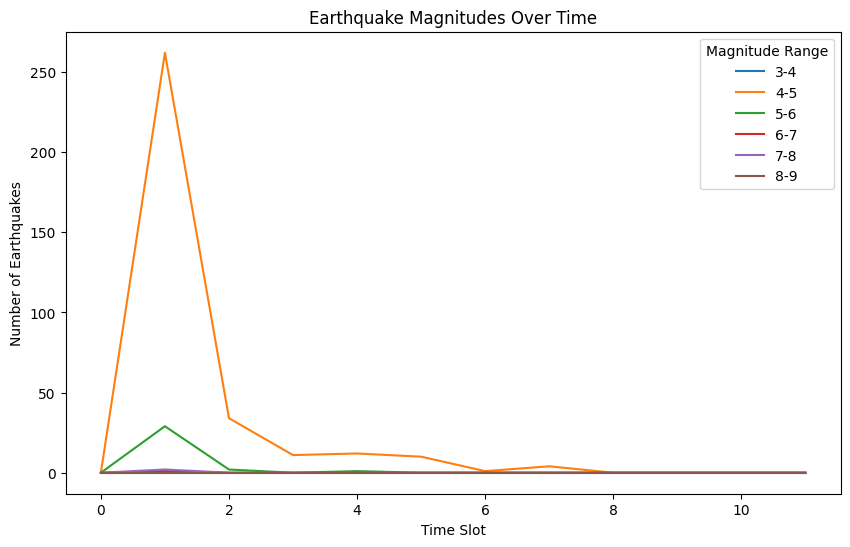

In [93]:
center_coordinate = (37.288, 37.043)  # Latitude, Longitude
radius_in_km = 100.0
time_interval = ('2023-01-01', '2024-01-01') # year-month-day
time_increment = '1M'  # 1 month increments

plot_earthquake_histogram(center_coordinate, radius_in_km, time_interval, time_increment)

In [86]:
def plot_earthquake_locations(center, radius, time_interval):
    """
    Plots the locations and magnitudes of the earthquake incidents in the given region.

    Parameters:
    center (tuple): A tuple containing the latitude and longitude of the center point (latitude, longitude).
    radius (float): The radius in kilometers.
    time_interval (tuple): A tuple containing the start and end dates in 'YYYY-MM-DD' format (start_date, end_date).
    """
    # Get the filtered earthquakes
    filtered_earthquakes = filter_earthquakes(center, radius, time_interval)
    
    # Set up the map boundaries
    lat_center, lon_center = center
    lat_min = lat_center - 2
    lat_max = lat_center + 2
    lon_min = lon_center - 5
    lon_max = lon_center + 5
    
    # Plot the locations
    plt.figure(figsize=(10, 8))
    
    # Set up the map
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')
    
    # Convert latitude and longitude to map coordinates
    x, y = m(filtered_earthquakes['Longitude'].values, filtered_earthquakes['Latitude'].values)
    
    # Create scatter plot
    scatter = m.scatter(x, y, c=filtered_earthquakes['Magnitude'], s=filtered_earthquakes['Magnitude']**2, 
                        cmap='coolwarm', alpha=0.6, edgecolors='w', linewidth=0.5)
    
    plt.colorbar(scatter, label='Magnitude')
    plt.title('Earthquake Locations and Magnitudes')
    plt.show()

/var/folders/sc/txcp_vws5hsbztxf_d9wby9w0000gn/T/ipykernel_64187/2762136904.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_data['Distance'] = time_filtered_data.apply(lambda row: pd.Series(calculate_distance(row)), axis=1)


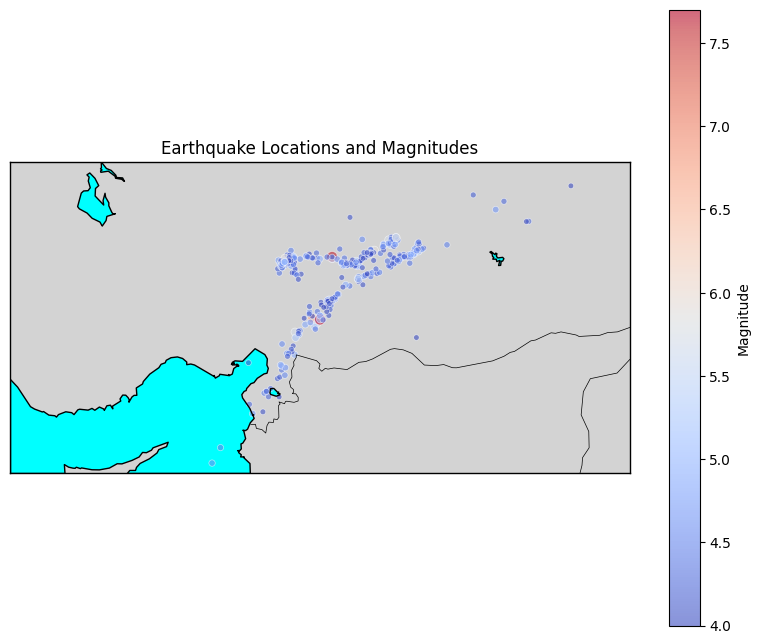

In [87]:
center_coordinate = (37.288, 37.043)  # Latitude, Longitude
radius_in_km = 1000.0
time_interval = ('2023-02-04', '2023-02-08') # year-month-day


plot_earthquake_locations(center_coordinate, radius_in_km, time_interval)